In [72]:
#Libraries

import torch
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets,transforms
import matplotlib.pyplot as plt

In [73]:
#Gan parameters

lr = 0.002
lat_dim = 100

#Dataset class

class dataset():
    def __init__(self,features,labels):
        self.features = features
        self.labels = labels

    def __len__(self):
        return len(self.features)
    
    def __getitem__(self,index):
        return self.features[index],self.labels[index]
    
#Gan Architecture

class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.Gan = nn.Sequential(nn.Linear(lat_dim,256),
                                 nn.ReLU(True),
                                 nn.Linear(256,512),
                                 nn.ReLU(True),
                                 nn.Linear(512,28*28),
                                 nn.Tanh())
    
    def forward(self,x):
        x = self.Gan(x)
        return x.view(-1,28,28)
    
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.Dis = nn.Sequential(nn.Linear(28*28,512),
                                 nn.LeakyReLU(0.2),
                                 nn.Linear(512,256),
                                 nn.LeakyReLU(0.2),
                                 nn.Linear(256,1))
    def forward(self,x):
        x = self.Dis(x)
        return x.view(x.size(0),-1)


In [74]:
#setting device as gpu and loading Fmnist dataset

device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

transform = transforms.ToTensor()

train_data = datasets.FashionMNIST(root = r"C:\Users\sarma\OneDrive\Desktop\Git work\Datasets",train=True,transform=transform)
test_data = datasets.FashionMNIST(root = r"C:\Users\sarma\OneDrive\Desktop\Git work\Datasets",train=False,transform=transform)

train_data = DataLoader(train_data,32,shuffle=True)
test_data = DataLoader(test_data,32,shuffle=False)

print("length of training data-",len(train_data))
print("length of testing data-",len(test_data))


cuda
length of training data- 1875
length of testing data- 313


In [107]:
#setting models and training

criterion = nn.BCEWithLogitsLoss()

Gen = Generator().to(device)
Gen_opt = optim.Adam(Gen.parameters(),lr=lr,betas=(0.5,0.999))

Dis = Discriminator().to(device)
Dis_opt = optim.Adam(Dis.parameters(),lr=lr,betas=(0.5,0.999))

epochs = 5
Gen.train()
Dis.train()

for epoch in range(epochs):

    Total_gen_loss = 0
    Total_dis_loss = 0

    for real_imgs,_ in train_data:
        real_imgs = real_imgs.to(device)
        batch_size = real_imgs.size(0)
        real_imgs = real_imgs.view(batch_size,-1)

        real_labels = torch.ones(batch_size,1,device=device)
        fake_labels = torch.zeros(batch_size,1,device=device)

        Gan_input = torch.randn(batch_size,lat_dim,device=device)
        fake_imgs = Gen(Gan_input)
        fake_imgs = fake_imgs.view(batch_size,-1)

        #Discriminator training

        Dis_real = Dis(real_imgs)
        Dis_fake = Dis(fake_imgs.detach())

        real_Dis_loss = criterion(Dis_real,real_labels)
        fake_Dis_loss = criterion(Dis_fake,fake_labels)

        loss_D = real_Dis_loss + fake_Dis_loss

        Dis_opt.zero_grad()
        loss_D.backward()
        Dis_opt.step()

        #Generator Training

        Dis_fake = Dis(fake_imgs)
        loss_G = criterion(Dis_fake,real_labels)
        Gen_opt.zero_grad()
        loss_G.backward()
        Gen_opt.step()
        Total_dis_loss += loss_D.item()
        Total_gen_loss += loss_G.item()
    print(f"Generator loss -- {Total_gen_loss/len(train_data)} , Discriminator loss -- {Total_dis_loss/len(train_data)} , Epoch = {epoch+1}")


Generator loss -- 0.924426780239741 , Discriminator loss -- 1.3539143562316895 , Epoch = 1
Generator loss -- 0.8999042074362437 , Discriminator loss -- 1.3708588394800822 , Epoch = 2
Generator loss -- 1.0781793993473052 , Discriminator loss -- 1.3200907466570537 , Epoch = 3
Generator loss -- 1.3031293874581655 , Discriminator loss -- 1.2092417786598206 , Epoch = 4
Generator loss -- 1.4879755383173625 , Discriminator loss -- 1.1450924338976542 , Epoch = 5


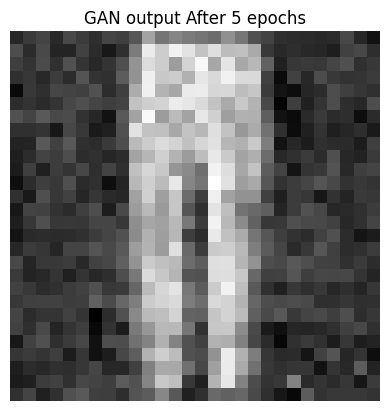

(16, 28, 28)


In [133]:
Gen.eval()
Dis.eval()

with torch.no_grad():
    noise = torch.randn(16,lat_dim,device=device)
    x = Gen(noise).cpu().numpy().reshape(-1,28,28)
    
plt.imshow(x[0],cmap = "gray")
plt.title(label=f"GAN output After 5 epochs")
plt.axis("off")
plt.show()
print(x.shape)